In [475]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as tf
import torch.optim as optim

from utils import flow2rgb
from utils import rgb2gray
from utils import read_flo
from utils import read_image
from torch.autograd import variable

from scipy.integrate import dblquad
from numpy.linalg import norm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [476]:
def numpy2torch(array):
    """ Converts 3D numpy HWC ndarray to 3D PyTorch CHW tensor."""
    assert (array.ndim == 3)

    result = array
    result = np.moveaxis(result,[1,2,0],[2,0,1])
    result = torch.from_numpy(result)
    
    return result


In [477]:
def torch2numpy(tensor):
    """ Convert 3D PyTorch CHW tensor to 3D numpy HWC ndarray."""
    assert (tensor.dim() == 3)

    result = tensor.permute(1,2,0).numpy()
    return result

In [478]:
def load_data(im1_filename, im2_filename, flo_filename):
    """ Loads images and flow ground truth. Returns 4D tensors."""
    i0_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+im1_filename
    i1_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+im2_filename
    flo_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+flo_filename
    i0 = read_image(i0_path)
    i0 = rgb2gray(i0)
    i1 = read_image(i1_path)
    i1 = rgb2gray(i1)    
    tensor1 = numpy2torch(i0).view(1,1,i0.shape[0],i0.shape[1])
    tensor2 = numpy2torch(i1).view(1,1,i1.shape[0],i1.shape[1])
    flow_gt = numpy2torch(read_flo(flo_path)).view(1,2,i1.shape[0],i1.shape[1])

    return tensor1, tensor2, flow_gt

In [479]:
def evaluate_flow(flow, flow_gt):
    """
    Evaluate the average endpoint error w.r.t the ground truth flow_gt.
    Excludes pixels, where u or v components of flow_gt have values > 1e9.
    """
    
    assert (flow.dim() == 4 and flow_gt.dim() == 4)
    assert (flow.size(1) == 2 and flow_gt.size(1) == 2)

    u = flow[0,0,:,:] * flow[0,0,:,:].le(1e9).float()
    v = flow[0,1,:,:] * flow[0,1,:,:].le(1e9).float()
    #u = flow[0,0,:,:]
    #v = flow[0,1,:,:]
    
    # Filter for invalid pixels
    u_gt = flow_gt[0,0,:,:] * flow_gt[0,0,:,:].le(1e9).float()
    v_gt = flow_gt[0,1,:,:] * flow_gt[0,1,:,:].le(1e9).float()

    # AEPE for each pixel
    errors = np.sqrt((u-u_gt)**2 + (v-v_gt)**2)
    
    #print(errors)
    
    # Average over all pixels
    aepe = sum(sum(errors))/errors.nelement()

    return aepe

In [480]:
def warp_image(im, flow):
    """ Warps given image according to the given optical flow."""
    assert (im.dim() == 4 and flow.dim() == 4)
    assert (im.size(1) in [1,3] and flow.size(1) == 2)
    """
    # Permute dimensions and range of flow for grid_sample()
    flow = flow.permute(0,2,3,1)
    flow[0,:,:,0] /= torch.max(flow[0,:,:,0])
    flow[0,:,:,1] /= torch.max(flow[0,:,:,1])
    
    warped = torch.nn.functional.grid_sample(im,flow)
    """
    norm_flow = torch.Tensor(flow.permute(0,2,3,1))
    # You have to add the meshgrid according to this:
    # https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/4
    W=norm_flow.size(1)
    H=norm_flow.size(2)
    
    """meshH, meshW= torch.meshgrid([torch.linspace(-1,1,W), torch.linspace(-1,1,H)])
    print("flow shape",norm_flow.shape, "H",H, "W",W)
    print("mesh H shape",meshH.shape)
    print("norm flow shape",norm_flow.shape)"""
    
    
    yy = torch.arange(0, W).view(1,-1).repeat(H,1)
    xx = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W)
    yy = yy.view(1,1,H,W)
    grid = torch.cat((xx,yy),1).float().permute(0,3,2,1)
       
    norm_flow = norm_flow + grid
    
    """norm_flow[:,:,:,0] = norm_flow[:,:,:,0] + meshW
    norm_flow[:,:,:,1] = norm_flow[:,:,:,1] + meshH"""
    
    
    norm_flow[:,:,:,0] = norm_flow[:,:,:,0] / (norm_flow.size(2)-1) # normalize it to (0,1)
    norm_flow[:,:,:,1] = norm_flow[:,:,:,1] / (norm_flow.size(1)-1) # normalize it to (0,1)
    
    
    norm_flow = norm_flow*2 - 1 # bringing it to the range (-1,1) for the grid_sample function
    # interpolate the image with the flow
    warped = tf.grid_sample(im, norm_flow)
    return warped

In [481]:
def visualize_warping_practice(im1, im2, flow_gt):
    """ Visualizes the result of warping the second image by ground truth."""
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) in [1,3] and im2.size(1) in [1,3] and flow_gt.size(1) == 2)
    
    warped_im2 = warp_image(im2, flow_gt)
    print(warped_im2.shape)
    
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("Image 1")
    plt.imshow(im1[0,0,:,:], cmap="gray")
    plt.subplot(132)
    plt.title("Warped Image 2")
    plt.imshow(warped_im2[0,0,:,:], cmap="gray")
    plt.subplot(133)
    plt.title("Difference")
    plt.imshow(im1[0,0,:,:]-warped_im2[0,0,:,:], cmap="gray")
    plt.show()
    
    return None

In [482]:
def energy_hs(im1, im2, flow, lambda_hs):
    """ Evalutes Horn-Schunck energy function."""
    assert (im1.dim() == 4 and im2.dim() == 4 and flow.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow.size(1) == 2)
    
    
    """
    def grad_u(x,y): return np.gradient(flow[0,0,:,:])[x,y]
    def grad_v(x,y): return np.gradient(flow[0,1,:,:])[x,y]
    # TODO: Interpolate It1 and It0
    def It1(x,y): return warp_image(im2,flow)[0,0,x,y]
    def It0(x,y): return im1[0,0,x,y]

    def integral(x,y):
        return (It1(x,y)-It0(x,y))**2 + lambda_hs*(np.norm(grad_u)**2 + np.norm(grad_v)**2)
    
    energy = dblquad(integral, -np.inf, np.inf, -np.inf, np.inf)
    """
    
    # Using sum instead of integral (discrete pixels in picture)
    It1 = warp_image(im2,flow)
    It0 = im1
    
    # TODO: use sobelfilter on u(x,y) and v(x,y)
    #sobel_filter = torch.tensor([[[[1., 2. , 1.], [0., 0., 0.], [-1., -2. , -1.]]]])
    #f = sobel_filter.expand(1,1,3,3)
    #grad_u = tf.conv2d(torch.unsqueeze(flow[0,0,:,:], 0), sobel_filter, padding=1)
    #grad_v = tf.conv2d(torch.unsqueeze(flow[0,1,:,:], 0), sobel_filter, padding=1)
    
    #
    """u = torch.autograd.Variable(flow[:,0,:,:].unsqueeze(0))
    v = torch.autograd.Variable(flow[:,1,:,:].unsqueeze(0))"""
    
    
    #flipped sobels, die durch 4 haben wir von ner anderen gruppe. Bei Tabea funktioniert es nicht ohne
    sobel_filter_x = torch.Tensor([[[[1., 0. , -1.], [2., 0., -2.], [1., 0. , -1.]]]])/4
    sobel_filter_y = torch.Tensor([[[ [1., 2., 1.], [0., 0., 0.],[-1., -2., -1.]]]])/4
    
    
    u = flow[:,0,:,:].unsqueeze(0)
    v = flow[:,1,:,:].unsqueeze(0)

    
    du_dx = tf.conv2d(u, sobel_filter_x, padding=1)    
    du_dy = tf.conv2d(u, sobel_filter_y, padding=1)                                         
    dv_dx = tf.conv2d(v, sobel_filter_x, padding=1)
    dv_dy = tf.conv2d(v, sobel_filter_y, padding=1)
    
    
                                             
    energy = torch.sum((It1-It0)**2) + torch.sum(lambda_hs*(du_dx**2+du_dy**2+(dv_dx**2+dv_dy**2)))
    
    """for x in np.arange(0, np.shape(It1)[0]):
        for y in np.arange(0, np.shape(It1)[1]):
            energy += (It1[x,y]-It0[x,y])**2 
            energy += lambda_hs*(norm([du_dx[0,0,x,y], du_dy[0,0,x,y]]) + norm([dv_dx[0,0,x,y], dv_dy[0,0,x,y]]))"""
    return energy

In [483]:
def estimate_flow(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter):
    """
    Estimate flow using HS with Gradient Descent.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow]
    """
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    # Initial flow
    flow = torch.rand(1,2,flow_gt.size(2),flow_gt.size(3),requires_grad=True)
    
    for i in np.arange(0, num_iter):
        
        # Forward pass
        # TODO: Warp im1 or im2??
        #Wenn dann bild 2 zu im1_estimate warpen, aber wir warpen doch schon in energy_hs
        #im2_estimate = warp_image(im1,flow)
        #loss = energy_hs(im1, im2_estimate, flow, lambda_hs)
        
        
        loss = energy_hs(im1,im2,flow,lambda_hs)
        
        if not i%10: print("Iteration ", i+1, "  Loss:", loss)
        # Backward pass
        loss.backward()
        
        update = flow.grad
        
        #ist das hier nicht gradient ascent?
        #flow += learning_rate * update
        
        with torch.no_grad():
            flow -= update * learning_rate 
        flow.grad.zero_()
    
    print("Gradient Descent AEPE: ", evaluate_flow(flow.data, flow_gt))
    with torch.no_grad():
        plt.figure()
        plt.title("Flow estimated with gradient descent")
        plt.imshow(flow2rgb(torch2numpy(flow.data.resize(2,388,584))))
        plt.show()
        
    
    return flow

In [484]:
def estimate_flow_LBFGS(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter):
    """
    Estimates flow using HS with LBFGS.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow
    """
    
    # Initial flow
    flo = torch.rand(1,2,flow_gt.size(2),flow_gt.size(3))
    flo.requires_grad = True
    
    global c
    c = 0
    
    optimizer = torch.optim.LBFGS(params=[flo], lr=learning_rate, max_iter=num_iter)

    
    def closure():
        global c
        c =  c + 1
        optimizer.zero_grad()
        #loss = energy_hs(im1,im2,flo,lambda_hs).clone().detach().requires_grad_(True)
        loss = energy_hs(im1,im2,flo,lambda_hs)
        if not c%50: print("Iteration: {} Loss: {}".format(c, loss))
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)
    
    print("LBFGS AEPE: ", evaluate_flow(flo.data, flow_gt))
    with torch.no_grad():
        plt.figure()
        plt.title("Flow estimated with LBFGS")
        plt.imshow(flow2rgb(torch2numpy(flo.data.resize(2,388,584))))
        plt.show()
        
    return

In [485]:
def estimate_flow_coarse_to_fine(im1, im2, flow_gt, lambda_hs, learning_rate,
                                 num_iter, num_level):
    """
    Estimates flow using HS with LBFGS in a coarse-to-fine scheme.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow
    """
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    return

In [486]:
def problem2():
    
    
    torch.autograd.set_detect_anomaly(True)

    # Loading data
    #im1, im2, flow_gt = load_data("frame10.png", "frame11.png", "flow10.flo")


    # Parameters
    lambda_hs = 0.0015
    num_iter = 400

    # Warping_practice
    #visualize_warping_practice(im1, im2, flow_gt)
    
    #print("HS: ", energy_hs(im1,im2,flow_gt,lambda_hs))
    
    # Gradient descent
    #learning_rate = 20.0
    #learning_rate = 0.02
    #estimate_flow(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter)

    
    # LBFGS
    learning_rate = 1.0
    estimate_flow_LBFGS(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter)

    # Coarse to fine
    #learning_rate = 1.0
    #num_level = 4
    #estimate_flow_coarse_to_fine(
    #    im1, im2, flow_gt, lambda_hs, learning_rate, num_iter, num_level)
    

Iteration: 50 Loss: 55.48115539550781
Iteration: 100 Loss: 35.421287536621094
Iteration: 150 Loss: 30.043872833251953
Iteration: 200 Loss: 27.820680618286133
Iteration: 250 Loss: 26.701444625854492
Iteration: 300 Loss: 26.06219482421875
Iteration: 350 Loss: 25.674196243286133
Iteration: 400 Loss: 25.379804611206055
LBFGS AEPE:  tensor(0.6474)


/home/yannik/.local/lib/python3.6/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


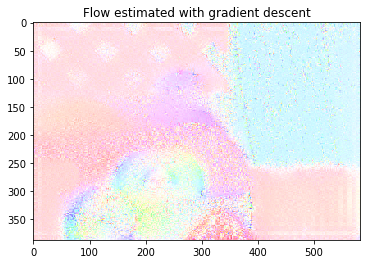

In [487]:
problem2()